In [1]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from sklearn.metrics import classification_report
from keras.applications import Xception
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers, callbacks
from tensorflow.keras.applications import EfficientNetV2B3
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, BatchNormalization

In [2]:
base_dir = 'D:/MODELING ML/DatasetV3_TampakAtas'

In [3]:
print(os.listdir(base_dir))

['0 Perubahan Warna Gigi', '1 Radang Gusi', '2 Gigi Berlubang', '3 Gigi Sehat', '4 Bukan Gigi']


In [4]:
# Menghitung jumlah gambar pada dataset
number_label = {}
total_files = 0
for i in os.listdir(base_dir):
    counting = len(os.listdir(os.path.join(base_dir, i)))
    number_label[i] = counting
    total_files += counting

print("Total Files : " + str(total_files))

Total Files : 2048


In [5]:
# Definisikan parameter
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 64
SEED = 999

In [6]:
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    fill_mode='nearest',
)

In [7]:
train_data = datagen.flow_from_directory(
    base_dir,
    class_mode='categorical',
    subset='training',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=SEED
)

valid_data = datagen.flow_from_directory(
    base_dir,
    class_mode='categorical',
    subset='validation',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=SEED
)

Found 1641 images belonging to 5 classes.
Found 407 images belonging to 5 classes.


In [8]:
# Load EfficientNetV2S with pretrained weights, excluding the top layers
base_model = tf.keras.applications.EfficientNetV2B3(
    include_top=False,
    weights="imagenet",
    input_shape=(224, 224, 3)
)

In [9]:
'''# Add custom top layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dense(5, activation='softmax')(x)  # 5 classes'''

"# Add custom top layers\nx = base_model.output\nx = GlobalAveragePooling2D()(x)\nx = Dense(128, activation='relu')(x)\nx = Dense(5, activation='softmax')(x)  # 5 classes"

In [10]:
# Add a global average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Add the final output layer with softmax activation
output = Dense(5, activation='softmax')(x)

# Create the model
model_TL = Model(inputs=base_model.input, outputs=output)


In [11]:
# Compile the model
model_TL.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
# Print model summary
model_TL.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          0 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │      1,080 │ normalization[0]… │
│                     │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        160 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │      5,760 │ stem_activation[… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, 112, 112,  │         64 │ block1a_project_… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_ac… │ (None, 112, 112,  │          0 │ block1a_project_… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_co… │ (None, 112, 112,  │      2,304 │ block1a_project_… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_bn  │ (None, 112, 112,  │         64 │ block1b_project_… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_ac… │ (None, 112, 112,  │          0 │ block1b_project_… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_drop        │ (None, 112, 112,  │          0 │ block1b_project_… │
│ (Dropout)           │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_add (Add)   │ (None, 112, 112,  │          0 │ block1b_drop[0][… │
│                     │ 16)               │            │ block1a_project_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_conv │ (None, 56, 56,    │      9,216 │ block1b_add[0][0] │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_bn   │ (None, 56, 56,    │        256 │ block2a_expand_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_act… │ (None, 56, 56,    │          0 │ block2a_expand_b

 Total params: 12,938,307 (49.36 MB)

 Trainable params: 12,829,091 (48.94 MB)

 Non-trainable params: 109,216 (426.62 KB)

In [12]:
callbacks_list = [
    tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)
]

In [13]:
steps_per_epoch = len(train_data) // BATCH_SIZE
validation_steps = len(valid_data) // BATCH_SIZE

history_TL = model_TL.fit(
    train_data,
    epochs=100,
    validation_data=valid_data,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=callbacks_list
)


Epoch 1/100


c:\Users\WIN 10\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


26/26 ━━━━━━━━━━━━━━━━━━━━ 1196s 27s/step - accuracy: 0.4626 - loss: 1.3840 - val_accuracy: 0.3243 - val_loss: 1.5655 - learning_rate: 1.0000e-04
Epoch 2/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 617s 22s/step - accuracy: 0.7868 - loss: 0.6537 - val_accuracy: 0.4988 - val_loss: 1.2389 - learning_rate: 1.0000e-04
Epoch 3/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 573s 21s/step - accuracy: 0.8588 - loss: 0.4355 - val_accuracy: 0.7002 - val_loss: 0.8072 - learning_rate: 1.0000e-04
Epoch 4/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 598s 22s/step - accuracy: 0.8978 - loss: 0.2924 - val_accuracy: 0.3808 - val_loss: 1.7421 - learning_rate: 1.0000e-04
Epoch 5/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 580s 22s/step - accuracy: 0.9309 - loss: 0.2303 - val_accuracy: 0.8108 - val_loss: 0.4760 - learning_rate: 1.0000e-04
Epoch 6/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 593s 22s/step - accuracy: 0.9568 - loss: 0.1506 - val_accuracy: 0.8256 - val_loss: 0.5275 - learning_rate: 1.0000e-04
Epoch 7/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 631s 24s/step - accuracy: 0.96

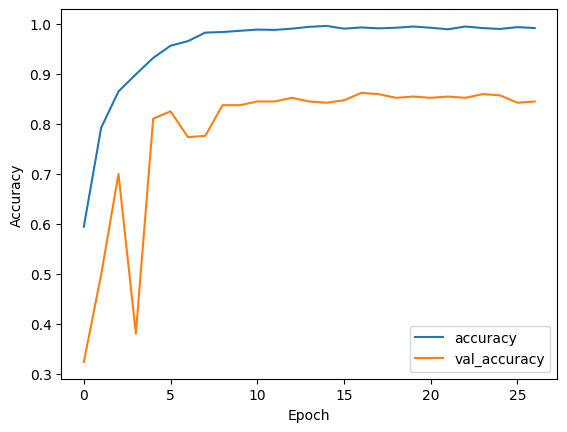

In [14]:
plt.plot(history_TL.history['accuracy'], label='accuracy')
plt.plot(history_TL.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

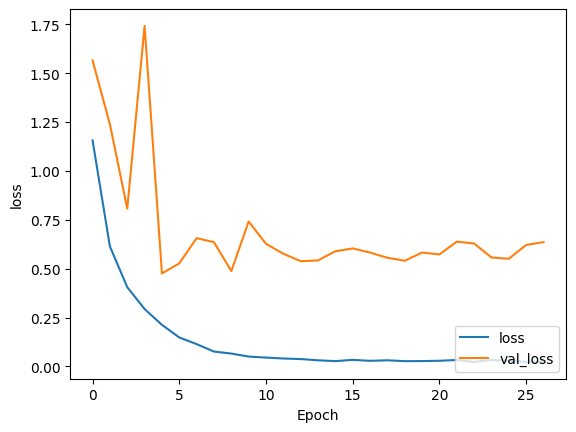

In [15]:
plt.plot(history_TL.history['loss'], label='loss')
plt.plot(history_TL.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.legend(loc='lower right')


In [16]:
model_TL.save('CNN_TL_INV3.h5')

In [17]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Define class labels
class_labels = ['0 Perubahan Warna Gigi', '1 Radang Gusi', '2 Gigi Berlubang', '3 Gigi Sehat', '4 Bukan Gigi']

# Path to the folder containing images
folder_path = 'F:/MODELING ML/simpan/lubang'  # Update with the path to your folder

# Load the model
loaded_model = load_model('CNN_TL_INV3.h5')

# Define image size (make sure this matches the size used in training)
IMAGE_SIZE = (224, 224)  # Update with the actual image size used in training

# Lists to store predicted labels and confidences
predicted_labels = []
confidences = []

# Iterate over all images in the folder
for filename in os.listdir(folder_path):
    image_path = os.path.join(folder_path, filename)

    # Load and preprocess the image
    img = load_img(image_path, target_size=IMAGE_SIZE)
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = x / 255.0  # Ensure that the image is scaled the same way as during training

    # Predict the class
    classes = loaded_model.predict(x, batch_size=1)
    predicted_class_index = np.argmax(classes)

    # Get the predicted label and confidence
    if predicted_class_index < len(class_labels):
        predicted_label = class_labels[predicted_class_index]
        confidence = classes[0][predicted_class_index]
    else:
        predicted_label = '2 Gigi Berlubang'
        confidence = 0.0

    # Store predicted label and confidence
    predicted_labels.append(predicted_label)
    confidences.append(confidence)

# Randomly select 10 images for display
random.seed(42)  # For reproducibility
display_indices = random.sample(range(len(predicted_labels)), min(10, len(predicted_labels)))

# Display the selected images
for index in display_indices:
    image_path = os.path.join(folder_path, os.listdir(folder_path)[index])

    # Display the image and prediction
    plt.imshow(load_img(image_path))
    plt.axis('off')
    plt.title(f"{predicted_labels[index]} ({confidences[index]:.2f})")
    plt.show()

# Calculate and print accuracy for '0 Perubahan Warna Gigi'
total_predictions = len(predicted_labels)
if total_predictions > 0:
    correct_predictions = predicted_labels.count('2 Gigi Berlubang')
    accuracy = correct_predictions / total_predictions
    print(f"Accuracy for '2 Gigi Berlubang': {accuracy:.2f}")
else:
    print("No images predicted as '2 Gigi Berlubang' found.")


FileNotFoundError: [WinError 3] The system cannot find the path specified: 'F:/MODELING ML/simpan/lubang'